In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb

%matplotlib inline

In [2]:
df = pd.read_csv('./data/data.csv')

In [3]:
df=df.rename(columns = {"Unnamed: 0": "Date"})

In [4]:
df.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
145915,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
145916,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
145917,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
145918,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
145919,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [5]:
df.Date = pd.to_datetime(df.Date)

In [6]:
df.set_index('Date', inplace = True)

In [7]:
df.sort_index(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145920 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.6 MB


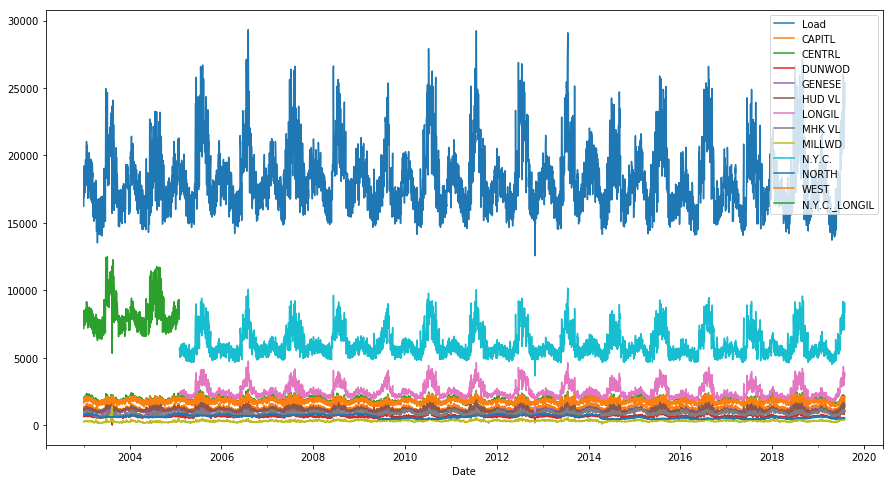

In [9]:
days = df.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

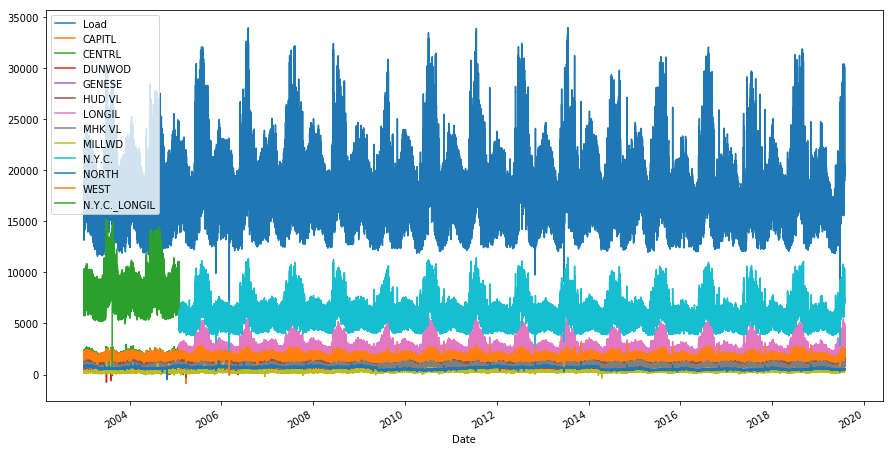

In [10]:
df.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [11]:
df.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,1947.066667,2294.158333,964.691667,1518.908333,1498.525000,3807.300000,1143.666667,430.083333,8408.100000,585.041667,2237.458333,NaN
2019-07-31 20:00:00,24219.675000,1896.200000,2219.283333,948.775000,1435.250000,1473.858333,3710.075000,1124.775000,435.516667,8286.316667,550.741667,2138.883333,NaN
2019-07-31 21:00:00,23578.041667,1842.125000,2147.391667,921.316667,1390.575000,1420.908333,3560.058333,1093.925000,423.700000,8140.341667,539.916667,2097.783333,NaN
2019-07-31 22:00:00,22177.316667,1699.375000,1982.983333,867.841667,1269.191667,1321.225000,3282.200000,1007.658333,387.158333,7849.108333,518.491667,1992.083333,NaN
2019-07-31 23:00:00,20562.291667,1551.416667,1798.033333,803.283333,1161.616667,1214.883333,2986.000000,914.350000,352.566667,7434.916667,514.658333,1830.566667,NaN


In [ ]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [ ]:
def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [100]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in [14, 28, 60, 90, 120]:
        df['MA_{0}'.format(str(i))] = df['Load'].rolling(24*i).mean() # rolling average
        df['MMAX_{0}'.format(str(i))] = df['Load'].rolling(24*i).max() # rolling maximum
        df['MMIN_{0}'.format(str(i))] = df['Load'].rolling(24*i).min() # rolling minimum
        df['MSTD_{0}'.format(str(i))] = df['Load'].rolling(24*i).std() # rolling standard deviation
        df['MSLOPE_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_slope(x), raw=True) # rolling slope
        df['MACC_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_acceleration(x),raw=True) # rolling acceleration
    for i in [1, 7, 30, 60, 90, 180, 365]:
        # add the lagged Load as a feature
        df['lag_{0}'.format(str(i))] = df['Load'].shift(24*i)
        # as well as the percentage of the current Load for each lagged closing price
        df['pct_{0}'.format(str(i))] = df['lag_{0}'.format(str(i))] / df['Load']
    keep_cols = df.columns.tolist()
    keep_cols.remove('Load')
    keep_cols.remove('date')
    X = df[keep_cols].fillna(0)
    if label:
        y = df[label]
        return X, y
    return X

In [101]:
def split_data(data, split_date):
        return data[data.index <= split_date].copy(), \
               data[data.index >  split_date].copy()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145290 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.5 MB


In [20]:
df.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127065
dtype: int64

In [21]:
df.dropna(subset = ['Load'], inplace=True)

In [22]:
df.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127065
dtype: int64

In [23]:
df.shape

(145290, 13)

In [68]:
drop_cols = df.columns.tolist()

In [69]:
drop_cols.remove('Load')

In [32]:
df.drop(drop_cols, axis=1, inplace=True)

In [72]:
df=df.fillna(0)

In [102]:
train, test = split_data(df, '01-Jan-2017')

In [103]:
X_train, y_train = create_features(train, label='Load')

In [104]:
X_test, y_test = create_features(test, label='Load')

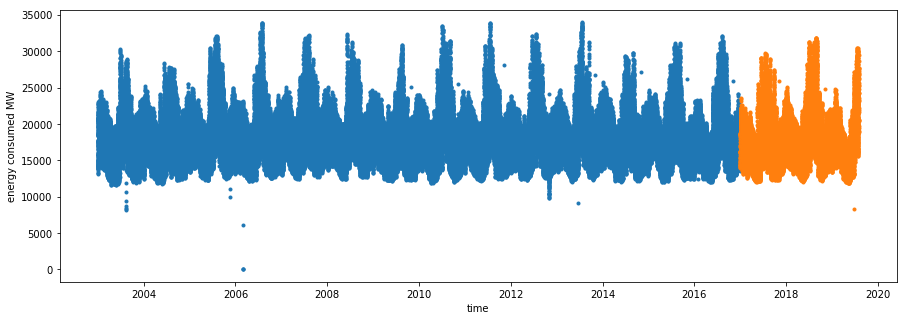

In [106]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('energy consumed MW')
plt.plot(X_train.index,y_train, '.')
plt.plot(X_test.index,y_test, '.')
plt.show()

In [108]:
X_train.head()

,MA_14,MMAX_14,MMIN_14,MSTD_14,MSLOPE_14,MACC_14,MA_28,MMAX_28,MMIN_28,MSTD_28,...,lag_365,pct_365,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,1,1,2003,1,1,1
2003-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,2,1,1,2003,1,1,1
2003-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,2,1,1,2003,1,1,1
2003-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3,2,1,1,2003,1,1,1
2003-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4,2,1,1,2003,1,1,1


In [109]:
X_train=X_train.fillna(0)

In [110]:
X_test=X_test.fillna(0)

In [111]:
y_test.head()

Date
2017-01-01 01:00:00    15071.408333
2017-01-01 02:00:00    14485.033333
2017-01-01 03:00:00    14097.658333
2017-01-01 04:00:00    13937.300000
2017-01-01 05:00:00    14033.241667
Name: Load, dtype: float64

In [112]:
X_train.shape, y_train.shape

((122686, 52), (122686,))

In [113]:
X_test.shape

(22604, 52)

In [115]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [116]:

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

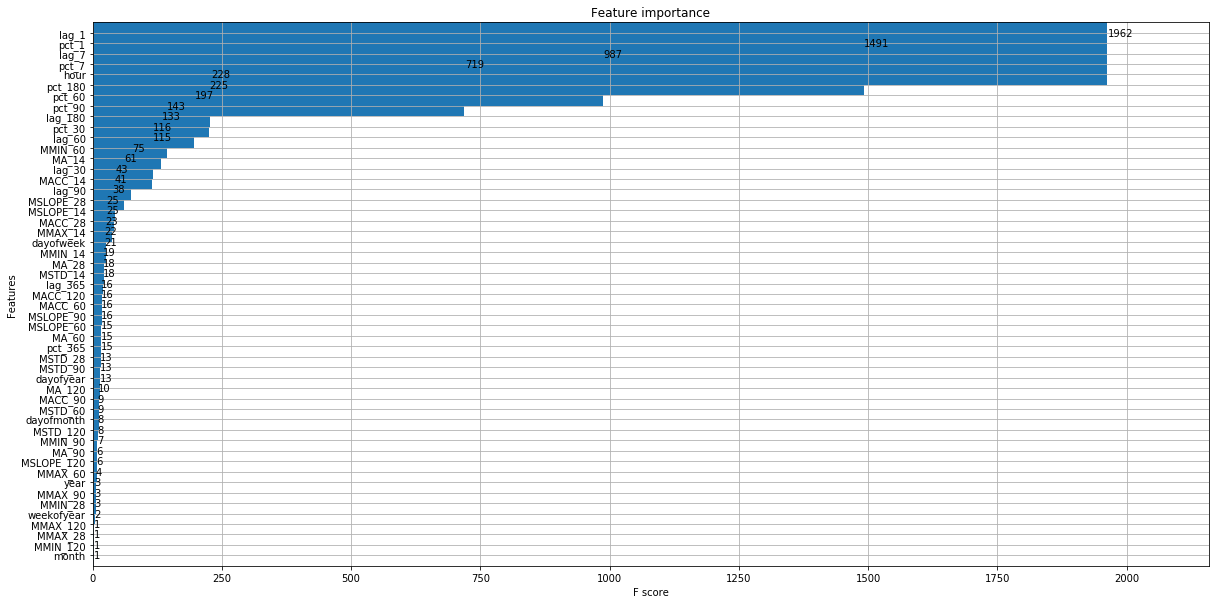

In [146]:
plt.rcParams["figure.figsize"] = (20, 10)
xgb.plot_importance(reg, height=10)


In [156]:
feats = reg.get_booster().get_score(importance_type="weight")
feats

{'lag_1': 1962,
 'lag_7': 987,
 'pct_1': 1491,
 'pct_180': 225,
 'pct_7': 719,
 'pct_90': 143,
 'pct_60': 197,
 'lag_60': 115,
 'hour': 228,
 'pct_30': 116,
 'lag_180': 133,
 'dayofweek': 21,
 'month': 1,
 'lag_90': 38,
 'MSTD_120': 8,
 'MACC_28': 23,
 'MSLOPE_90': 16,
 'MMIN_60': 75,
 'MSLOPE_120': 6,
 'MA_14': 61,
 'MMIN_28': 3,
 'MMAX_14': 22,
 'MMAX_60': 4,
 'lag_30': 43,
 'MSTD_14': 18,
 'pct_365': 15,
 'MA_60': 15,
 'MA_120': 10,
 'MSLOPE_14': 25,
 'MACC_14': 41,
 'dayofyear': 13,
 'MA_28': 18,
 'MSTD_90': 13,
 'MMIN_14': 19,
 'MACC_60': 16,
 'MACC_120': 16,
 'MMIN_90': 7,
 'MSLOPE_28': 25,
 'MSLOPE_60': 15,
 'MSTD_60': 9,
 'MMAX_90': 3,
 'MSTD_28': 13,
 'weekofyear': 2,
 'MA_90': 6,
 'year': 3,
 'lag_365': 16,
 'dayofmonth': 8,
 'MMIN_120': 1,
 'MMAX_28': 1,
 'MACC_90': 9,
 'MMAX_120': 1}

In [154]:
list(feats.keys())

['lag_1',
 'lag_7',
 'pct_1',
 'pct_180',
 'pct_7',
 'pct_90',
 'pct_60',
 'lag_60',
 'hour',
 'pct_30',
 'lag_180',
 'dayofweek',
 'month',
 'lag_90',
 'MSTD_120',
 'MACC_28',
 'MSLOPE_90',
 'MMIN_60',
 'MSLOPE_120',
 'MA_14',
 'MMIN_28',
 'MMAX_14',
 'MMAX_60',
 'lag_30',
 'MSTD_14',
 'pct_365',
 'MA_60',
 'MA_120',
 'MSLOPE_14',
 'MACC_14',
 'dayofyear',
 'MA_28',
 'MSTD_90',
 'MMIN_14',
 'MACC_60',
 'MACC_120',
 'MMIN_90',
 'MSLOPE_28',
 'MSLOPE_60',
 'MSTD_60',
 'MMAX_90',
 'MSTD_28',
 'weekofyear',
 'MA_90',
 'year',
 'lag_365',
 'dayofmonth',
 'MMIN_120',
 'MMAX_28',
 'MACC_90',
 'MMAX_120']

In [125]:
y_pred = reg.predict(X_test)


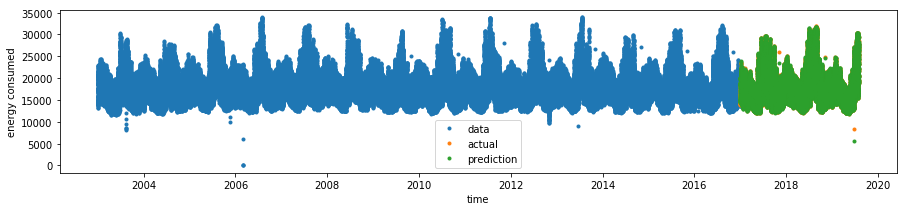

In [127]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(X_train.index, y_train, '.', label='data')
plt.plot(X_test.index, y_test, '.', label='actual')
plt.plot(X_test.index, y_pred, '.', label='prediction')
plt.legend()
# plt.xlim(left=date_from, right=date_to)
plt.show()

In [128]:
def plot_(data, target, begin, end, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(begin, end))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(data.index, target, label='data')
    plt.plot(X_test.index, y_pred, label='prediction')
    plt.legend()
    plt.xlim(left=begin, right=end)

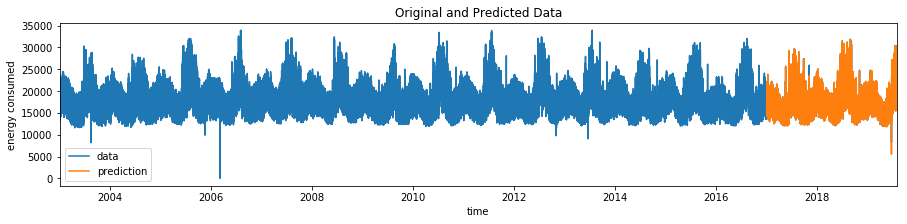

In [129]:
plot_(df, df['Load'], df.index[0].date(), df.index[-1].date(), 'Original and Predicted Data')

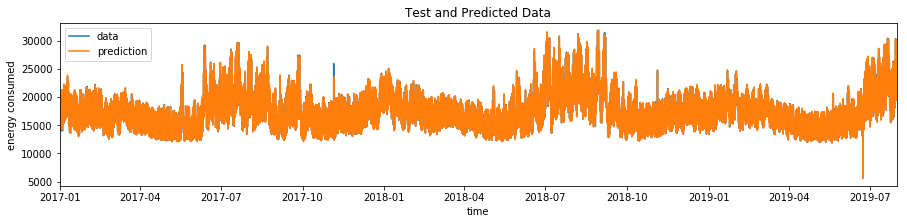

In [131]:
plot_(X_test, y_test, y_test.index[0].date(), y_test.index[-1].date(), 'Test and Predicted Data')

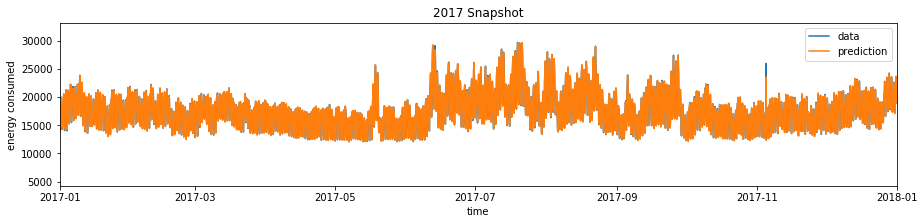

In [ ]:
plot_(X_test, y_test, '01-01-2017', '01-01-2018', '2017 Snapshot')


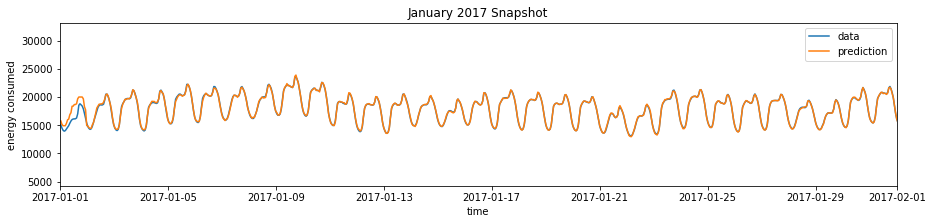

In [132]:
plot_(X_test, y_test, '01-01-2017', '02-01-2017', 'January 2017 Snapshot')


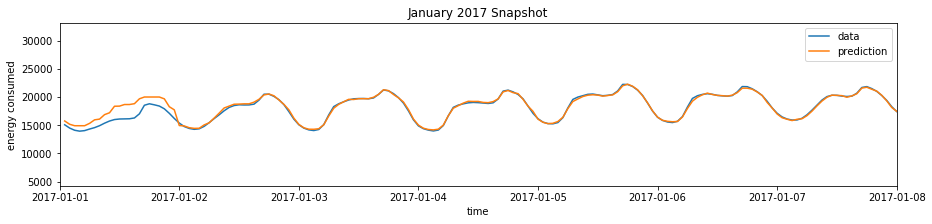

In [158]:
plot_(X_test, y_test, '01-01-2017', '01-08-2017', 'January 2017 Snapshot')
